## A Movie Recommender System

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import ast
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

In [2]:
credits=pd.read_csv('tmdb_5000_credits.csv')

In [3]:
movies=pd.read_csv('tmdb_5000_movies.csv')

In [4]:
credits.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


### Data Preprocessing

In [5]:
movies.head(n=2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500


In [6]:
movies.tail(n=2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
4801,0,[],http://shanghaicalling.com/,126186,[],en,Shanghai Calling,When ambitious New York attorney Sam is sent t...,0.857008,[],"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-05-03,0,98.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,A New Yorker in Shanghai,Shanghai Calling,5.7,7
4802,0,"[{""id"": 99, ""name"": ""Documentary""}]",NaN,25975,"[{""id"": 1523, ""name"": ""obsession""}, {""id"": 224...",en,My Date with Drew,Ever since the second grade when he first saw ...,1.929883,"[{""name"": ""rusty bear entertainment"", ""id"": 87...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2005-08-05,0,90.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,NaN,My Date with Drew,6.3,16


In [7]:
movies.isnull().sum()

budget                     0
genres                     0
homepage                3091
id                         0
keywords                   0
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies       0
production_countries       0
release_date               1
revenue                    0
runtime                    2
spoken_languages           0
status                     0
tagline                  844
title                      0
vote_average               0
vote_count                 0
dtype: int64

#### There is alittle observation, the data inside genre column has an empty list but which isn't showing as an empty data, so we will check the count where we have this empty list and drop them

In [8]:
movies[movies['genres']=='[]'].count()

budget                  28
genres                  28
homepage                 5
id                      28
keywords                28
original_language       28
original_title          28
overview                28
popularity              28
production_companies    28
production_countries    28
release_date            27
revenue                 28
runtime                 28
spoken_languages        28
status                  28
tagline                  3
title                   28
vote_average            28
vote_count              28
dtype: int64

This empty list data are going to be drop here

In [9]:
empty_list=movies[movies['genres']=='[]']

In [10]:
not_empty_list=movies[movies['genres']!= '[]'] #so, we will convert this to a dataframe

The data has been dropped, we convert the new data to a dataframe

In [11]:
movies= pd.DataFrame(not_empty_list)

In [12]:
movies.tail(n=2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
4800,0,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 18, ""nam...",http://www.hallmarkchannel.com/signedsealeddel...,231617,"[{""id"": 248, ""name"": ""date""}, {""id"": 699, ""nam...",en,"Signed, Sealed, Delivered","""Signed, Sealed, Delivered"" introduces a dedic...",1.444476,"[{""name"": ""Front Street Pictures"", ""id"": 3958}...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2013-10-13,0,120.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,NaN,"Signed, Sealed, Delivered",7.0,6
4802,0,"[{""id"": 99, ""name"": ""Documentary""}]",NaN,25975,"[{""id"": 1523, ""name"": ""obsession""}, {""id"": 224...",en,My Date with Drew,Ever since the second grade when he first saw ...,1.929883,"[{""name"": ""rusty bear entertainment"", ""id"": 87...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2005-08-05,0,90.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,NaN,My Date with Drew,6.3,16


In [13]:
movies.shape

(4775, 20)

In [14]:
movies.isnull().sum()

budget                     0
genres                     0
homepage                3068
id                         0
keywords                   0
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies       0
production_countries       0
release_date               0
revenue                    0
runtime                    2
spoken_languages           0
status                     0
tagline                  819
title                      0
vote_average               0
vote_count                 0
dtype: int64

In [15]:
movies.fillna(0, inplace=True)

So, we check for any missing data in our credits data also

In [16]:
credits.isnull().sum()

movie_id    0
title       0
cast        0
crew        0
dtype: int64

#### From the movies data, the genre is one of the useful column that will be needed,so there is a need to clean and pre-process

In [17]:
movies['genres'][0]

'[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]'

In [18]:
movies['genres'] = movies['genres'].map(lambda x: ast.literal_eval(x))

In [19]:
def preprocess_genres(gen):
    all_genres=[]
    for i in gen:
        if i.get('name') == "Science Fiction":
            scifi = "Sci-Fi"
            all_genres.append(scifi)
        else:
            value=i.get('name')
            all_genres.append(value)
    if all_genres == []:
        return('there are no names')
    else:
        return("|".join(all_genres))
    

In [20]:
movies['genres'] = movies['genres'].map(lambda x: preprocess_genres(x))

In [21]:
movies['genres'][0:3]

0    Action|Adventure|Fantasy|Sci-Fi
1           Adventure|Fantasy|Action
2             Action|Adventure|Crime
Name: genres, dtype: object

In [22]:
movies.columns

Index([u'budget', u'genres', u'homepage', u'id', u'keywords',
       u'original_language', u'original_title', u'overview', u'popularity',
       u'production_companies', u'production_countries', u'release_date',
       u'revenue', u'runtime', u'spoken_languages', u'status', u'tagline',
       u'title', u'vote_average', u'vote_count'],
      dtype='object')

##### So, the genre has been handled, so we will merge our movie data with credits data

In [23]:
credits.columns = ['id','tittle','cast','crew']
data= movies.merge(credits,on='id')

In [24]:
data.head(n=2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,tittle,cast,crew
0,237000000,Action|Adventure|Fantasy|Sci-Fi,http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,Adventure|Fantasy|Action,http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."


There are some columns that needs to be cleaned and preprocess in our data especially the cast, crew, keywords, release_date,production countries and production compananies column, whereby for the cast we need to have the names of people involved in a particular movie while for the crew the directors name is needed, so we work on extracting it here by using the functions below.

..

For the cast column the top 3 cast is going to be picked, while the keywords column, the top3 words are going to be picked.

In [25]:
data['cast'] = data['cast'].map(lambda x: ast.literal_eval(x))
data['crew'] = data['crew'].map(lambda x: ast.literal_eval(x))
data['keywords'] = data['keywords'].map(lambda x: ast.literal_eval(x))
data['production_countries'] = data['production_countries'].map(lambda x: ast.literal_eval(x))
data['production_companies'] = data['production_companies'].map(lambda x: ast.literal_eval(x))

In [26]:
def preprocess_cast(cast):
    total=[]
    for i in cast:
        if i:
            names=i.get('name')
            total.append(names)
        if len(total) > 3:
            total= total[0:3]
            return total
    if total:
        return (','.join(total))
    else:
        return('no item')

In [27]:
data['cast'] = data['cast'].map(lambda x: preprocess_cast(x))

In [28]:
data['cast'][0]

['Sam Worthington', 'Zoe Saldana', 'Sigourney Weaver']

In [29]:
def preprocess_crew(crew):
    names=[]
    for i in crew:
        if i.get('job')=='Director':
            names.append(i['name'])
            return (",".join(names))
    return np.nan
        

In [30]:
data['crew'] = data['crew'].map(lambda x: preprocess_crew(x))

In [31]:
data['crew'][0]

'James Cameron'

In [32]:
data['release_date'].head(n=2)

0    2009-12-10
1    2007-05-19
Name: release_date, dtype: object

In [33]:
def preprocess_year(x):
    for i in x:
        y= x.split('-')[0]
    return y

In [34]:
data['release_date'] = data['release_date'].map(lambda x: preprocess_year(x))

In [35]:
def preprocess_keyword(keyword):
    total=[]
    for i in keyword:
        if i:
            the_keyword=i.get('name')
            total.append(the_keyword)
        if len(total) > 3:
            total= total[0:3]
            return total
    if total:
        return(",".join(total))
    else:
        return ("there are no items in the list")

In [36]:
data['keywords'] = data['keywords'].map(lambda x: preprocess_keyword(x))

In [37]:
#data['cast'][0]

In [38]:
data['keywords'][0]

['culture clash', 'future', 'space war']

In [39]:
data['production_countries'][0]

[{'iso_3166_1': 'US', 'name': 'United States of America'},
 {'iso_3166_1': 'GB', 'name': 'United Kingdom'}]

In [40]:
def preprocess_countries(countries):
    total=[]
    for i in countries:
        if i:
            the_countries=i.get('name')
            total.append(the_countries)
        else:
            return('no item')
    if total:
        return(",".join(total))
    else:
        ("there are no items in the list")

In [41]:
data['production_countries'] = data['production_countries'].map(lambda x: preprocess_countries(x))

In [42]:
data['production_companies'][0]

[{'id': 289, 'name': 'Ingenious Film Partners'},
 {'id': 306, 'name': 'Twentieth Century Fox Film Corporation'},
 {'id': 444, 'name': 'Dune Entertainment'},
 {'id': 574, 'name': 'Lightstorm Entertainment'}]

In [43]:
def preprocess_companies(companies):
    total=[]
    for i in companies:
        if i:
            the_companies=i.get('name')
            total.append(the_companies)
        else:
            return('no item')
    if total:
        return(",".join(total))
    else:
        ("there are no items in the list")

In [44]:
data['production_companies'] = data['production_companies'].map(lambda x: preprocess_keyword(x))

..

So, we've handled each column mentioned which needs to be preprocess, now we'll perform exploratory data analysis on our data

In [45]:
col=[]
for i in data.columns:
    col.append(i)
print(col)

['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language', 'original_title', 'overview', 'popularity', 'production_companies', 'production_countries', 'release_date', 'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'vote_average', 'vote_count', 'tittle', 'cast', 'crew']


# EDA

### Most Popular Movie

#### Here, we will sort movie by using the popularity column to know the most popular movies and their date

In [46]:
data[['original_title', 'popularity', 'release_date']].sort_values('popularity', ascending=False).head(10)

,original_title,popularity,release_date
546,Minions,875.581305,2015
95,Interstellar,724.247784,2014
788,Deadpool,514.569956,2016
94,Guardians of the Galaxy,481.098624,2014
127,Mad Max: Fury Road,434.278564,2015
28,Jurassic World,418.708552,2015
199,Pirates of the Caribbean: The Curse of the Bla...,271.972889,2003
82,Dawn of the Planet of the Apes,243.791743,2014
200,The Hunger Games: Mockingjay - Part 1,206.227151,2014
88,Big Hero 6,203.734590,2014


### Most voted movie

#### Here, we will check the most voted movie using the vote count provided in the data

In [47]:
data[['original_title', 'vote_count', 'release_date']].sort_values('vote_count', ascending=False).head(10)

,original_title,vote_count,release_date
96,Inception,13752,2010
65,The Dark Knight,12002,2008
0,Avatar,11800,2009
16,The Avengers,11776,2012
788,Deadpool,10995,2016
95,Interstellar,10867,2014
287,Django Unchained,10099,2012
94,Guardians of the Galaxy,9742,2014
426,The Hunger Games,9455,2012
127,Mad Max: Fury Road,9427,2015


#### Below we'll check the year the movies were released and the amount spent on the movies.
From the graph we can deduce more revenue were accumulated during 2012-2016, more like recent years.

Text(0.5,1,'Year when the movie release and revenue')

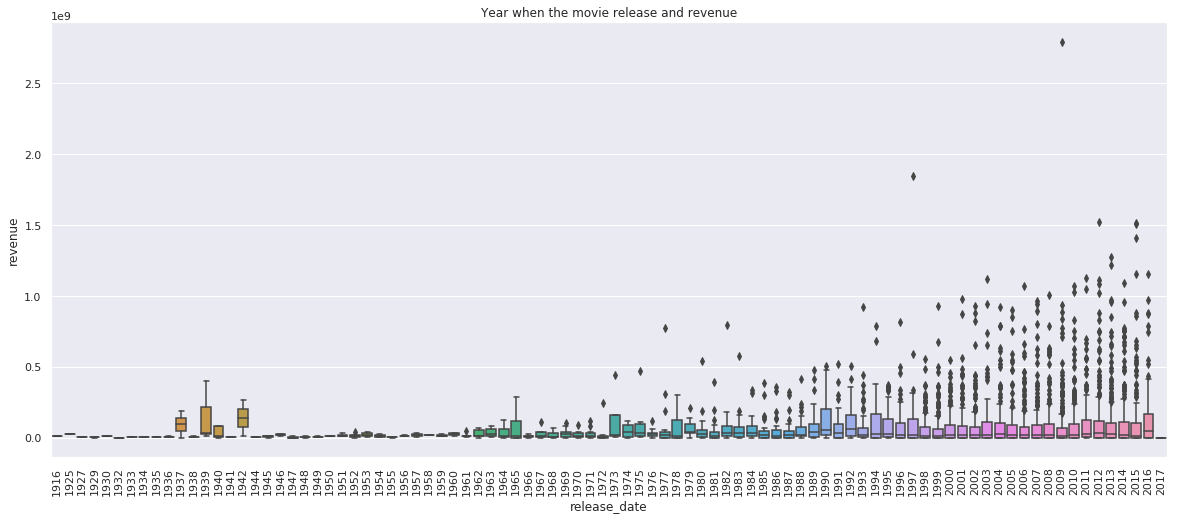

In [48]:
sns.set(rc={'figure.figsize':(20, 8)})
g = sns.boxplot(x='release_date', y='revenue', data=data)
plt.xticks(rotation=90)
plt.title('Year when the movie release and revenue')

Here, we check the year more movies were released

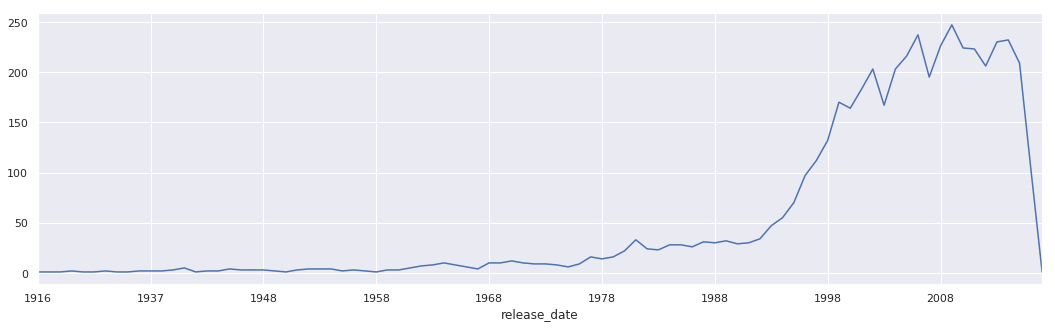

In [49]:
year_count = data.groupby('release_date')['original_title'].count()
plt.figure(figsize=(18,5))
year_count.plot()

..

### Shortest Movies

We also checked for the shortest movies by using the runtime columns to know if there are any movies whose time is lower than the standard time for most movies.

In [50]:
data[data['runtime'] > 0][['runtime', 'original_title', 'release_date']].sort_values('runtime').head(10)

,runtime,original_title,release_date
4455,14.0,Vessel,2012
4684,25.0,A Charlie Brown Christmas,1965
3626,41.0,Sea Rex 3D: Journey to a Prehistoric World,2010
3471,42.0,Dolphins and Whales: Tribes of the Ocean,2008
3354,46.0,Michael Jordan to the Max,2000
4729,47.0,The Call of Cthulhu,2005
3403,53.0,Alpha and Omega: The Legend of the Saw Tooth Cave,2014
4660,59.0,Chats perchés,2004
4758,60.0,Stories of Our Lives,2014
1620,63.0,Winnie the Pooh,2011


### Longest Movies
Movies which takes longer time were also checked below using the runtime columns

In [51]:
data[data['runtime'] > 0][['runtime', 'original_title', 'release_date']].sort_values('runtime', ascending=False).head(10)

,runtime,original_title,release_date
2384,338.0,Carlos,2010
2631,276.0,The Company,2007
1922,254.0,Gettysburg,1993
1125,248.0,Cleopatra,1963
2373,242.0,Hamlet,1996
3510,240.0,Emma,2009
3813,238.0,Gone with the Wind,1939
1663,229.0,Once Upon a Time in America,1984
4486,225.0,Woodstock,1970
1109,219.0,Heaven's Gate,1980


..

## Building the recommender System

A content-based recommender approach is going to be used for this project. Which is based on, if a user likes an item, a user can as well be recommended with a similar item, which leverages on the data user provides. 

There are 2 approaches when using a content-based recommender, which is;
The Description-based recommender system &
The MetaData based recommender system

The MetaData Based recommender system is more robust, that's what we'll use for this project


In [45]:
data.columns

Index([u'budget', u'genres', u'homepage', u'id', u'keywords',
       u'original_language', u'original_title', u'overview', u'popularity',
       u'production_companies', u'production_countries', u'release_date',
       u'revenue', u'runtime', u'spoken_languages', u'status', u'tagline',
       u'title', u'vote_average', u'vote_count', u'tittle', u'cast', u'crew'],
      dtype='object')

In [46]:
new_data = data[['genres','cast','keywords', 'vote_average','vote_count','crew','original_title','id']]

In [47]:
new_data.head(n=2)

,genres,cast,keywords,vote_average,vote_count,crew,original_title,id
0,Action|Adventure|Fantasy|Sci-Fi,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]","[culture clash, future, space war]",7.2,11800,James Cameron,Avatar,19995
1,Adventure|Fantasy|Action,"[Johnny Depp, Orlando Bloom, Keira Knightley]","[ocean, drug abuse, exotic island]",6.9,4500,Gore Verbinski,Pirates of the Caribbean: At World's End,285


So here, a metric is needed to score or rate the movie.THis metric will help in recommending the best rated movie. In doing this the IMDB weighted rating formula will be used. (v/v+m .R) + (m/v+m .C)

In [48]:
C= new_data['vote_average'].mean()
C

6.114198952879576

for a movie to feature , it must have more votes than at least 90% of the movies in the list.

In [49]:
m= new_data['vote_count'].quantile(0.9)
m

1860.800000000001

Filtering out qualified movies 

In [50]:
qualify_movies = new_data.loc[new_data['vote_count'] >= m]

The weighted rating is calcualted using the formular below

In [51]:
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [52]:
qualify_movies['score'] = qualify_movies.apply(weighted_rating, axis=1)

Movies sorted out based on their score below

So from above, based on the weighted rating calculated we can check out the score for each movies.

In [55]:
#Sort movies based on score calculated above
qualify_movies = qualify_movies.sort_values('score', ascending=False)

#Print the top 15 movies
qualify_movies[['original_title', 'vote_count', 'vote_average', 'score']].head(10)

,original_title,vote_count,vote_average,score
1881,The Shawshank Redemption,8205,8.5,8.058952
662,Fight Club,9413,8.3,7.939222
65,The Dark Knight,12002,8.2,7.920023
3232,Pulp Fiction,8428,8.3,7.904683
96,Inception,13752,8.1,7.863324
3337,The Godfather,5893,8.4,7.851441
95,Interstellar,10867,8.1,7.809677
809,Forrest Gump,7927,8.2,7.803460
329,The Lord of the Rings: The Return of the King,8064,8.1,7.727682
1990,The Empire Strikes Back,5879,8.2,7.698532


So here, we'll proceed in building our recommender system. We ensure to preprocess each column we needed [cast, director, keyword, genres], before creating the count matrix

In [68]:
new_data['cast'] = new_data['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [69]:
new_data['genres'] = new_data['genres'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [70]:
new_data['crew'] = new_data['crew'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))
#new_data['crew'] = new_data['crew'].apply(lambda x: [x,x])

In [71]:
stemmer = SnowballStemmer('english')
data['keywords'] = data['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
data['keywords'] = data['keywords'].apply(lambda x: [(i.replace(" ", "")) for i in x])

In [72]:
def create_total(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['crew'] + ' ' + ' '.join(x['genres'])

In [73]:
new_data['total'] = new_data.apply(create_total, axis=1)

..

#### Countvectorizer will be used to create the count matrix for the total data and then we find the 

#### cosine similarities to return most similar movies

In [75]:
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix = count.fit_transform(new_data['total'])

In [76]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [79]:
new_data = new_data.reset_index()
titles = new_data['original_title']
indices = pd.Series(new_data.index, index=new_data['original_title'])

In [82]:
def get_recommendations(title):
    idx = indices[title]
    similarity_scores = list(enumerate(cosine_sim[idx]))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    similarity_scores = similarity_scores[1:51]
    movie_indices = [i[0] for i in similarity_scores]
    return titles.iloc[movie_indices]

In [86]:
get_recommendations('Avatar').head(n=10)

2403                        Aliens
25                         Titanic
282                      True Lies
279     Terminator 2: Judgment Day
587                      The Abyss
3439                The Terminator
4110                        Subway
812                     Pocahontas
3184               The Ice Pirates
4495            A Hard Day's Night
Name: original_title, dtype: object

So here, we were able to find the most similar movies to Avatar, we can as well use it for other movie title also

Based on the weighted rating calculated, we can build list of recommended movie using a particular genres

In [123]:
subset= qualify_movies.copy()

In [124]:
value = subset.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
value.name = 'genres'
value_df = subset.drop('genres', axis=1).join(value)

In [99]:
value_df.head(n=2)

,cast,keywords,vote_average,vote_count,crew,original_title,id,score,genres
1881,"[Tim Robbins, Morgan Freeman, Bob Gunton]","[prison, corruption, police brutality]",8.5,8205,Frank Darabont,The Shawshank Redemption,278,8.058952,Drama|Crime
662,"[Edward Norton, Brad Pitt, Meat Loaf]","[support group, dual identity, nihilism]",8.3,9413,David Fincher,Fight Club,550,7.939222,Drama


In [127]:
def make_toplist(genre,  percentile=0.85):
    df = value_df[value_df['genres'] == genre]
    qualified = df.sort_values('score', ascending=False).head(250)
    
    return qualified

### Top 10 Drama movies

In [130]:
make_toplist('Drama').head(10)

,cast,keywords,vote_average,vote_count,crew,original_title,id,score,genres
662,"[Edward Norton, Brad Pitt, Meat Loaf]","[support group, dual identity, nihilism]",8.3,9413,David Fincher,Fight Club,550,7.939222,Drama
3865,"[Miles Teller, J.K. Simmons, Melissa Benoist]","[jazz, obsession, conservatory]",8.3,4254,Damien Chazelle,Whiplash,244786,7.634837,Drama
3057,"[Edward Norton, Edward Furlong, Beverly D'Angelo]","[usa, neo-nazi, prison]",8.2,3016,Tony Kaye,American History X,73,7.404138,Drama
3719,"[Jack Nicholson, Louise Fletcher, Danny DeVito]","[individual, rebel, self-destruction]",8.2,2919,Milo\u0161 Forman,One Flew Over the Cuckoo's Nest,510,7.387987,Drama
2453,"[Robin Williams, Ethan Hawke, Robert Sean Leon...","[individual, philosophy, poetry]",8.1,2705,Peter Weir,Dead Poets Society,207,7.290683,Drama
2516,"[Kevin Spacey, Annette Bening, Thora Birch]","[male nudity, female nudity, adultery]",7.9,3313,Sam Mendes,American Beauty,14,7.257722,Drama
4583,"[Henry Fonda, Martin Balsam, John Fiedler]","[judge, jurors, sultriness]",8.2,2078,Sidney Lumet,12 Angry Men,389,7.214609,Drama
2975,"[Robin Williams, Matt Damon, Ben Affleck]","[baseball, boston, professor]",7.9,2811,Gus Van Sant,Good Will Hunting,489,7.188707,Drama
1813,"[Clint Eastwood, Christopher Carley, Bee Vang]","[rape, war veteran, immigration]",7.8,3086,Clint Eastwood,Gran Torino,13223,7.165865,Drama
824,"[Will Smith, Jaden Smith, Thandie Newton]","[san francisco, single parent, homeless person]",7.7,2525,Gabriele Muccino,The Pursuit of Happyness,1402,7.027179,Drama


### Top 10 comedy movie

In [145]:
make_toplist('Comedy').head(10)

,cast,keywords,vote_average,vote_count,crew,original_title,id,score,genres
1356,"[Bradley Cooper, Ed Helms, Zach Galifianakis]","[underwear, tiger, stag night]",7.2,6173,Todd Phillips,The Hangover,18785,6.948505,Comedy
1173,"[Robert De Niro, Anne Hathaway, Rene Russo]","intern,woman director",7.1,1881,Nancy Meyers,The Intern,257211,6.609760,Comedy
2392,"[Jonah Hill, Michael Cera, Christopher Mintz-P...","[becoming an adult, high school, young people]",7.0,2100,Greg Mottola,Superbad,8363,6.583847,Comedy
2330,"[Lindsay Lohan, Rachel McAdams, Tim Meadows]","[female friendship, high school, fish out of w...",6.9,2320,Mark Waters,Mean Girls,10625,6.550254,Comedy
3263,"[Emma Stone, Stanley Tucci, Amanda Bynes]","[lie, high school, school]",6.7,2210,Will Gluck,Easy A,37735,6.432225,Comedy
427,"[Bradley Cooper, Ed Helms, Zach Galifianakis]","[sun glasses, interpol, undercover cop]",6.2,3739,Todd Phillips,The Hangover Part II,45243,6.171489,Comedy
2312,"[Seth Rogen, Zac Efron, Rose Byrne]","[alcohol, baby, party]",6.2,2713,Nicholas Stoller,Neighbors,195589,6.165093,Comedy
616,"[Mark Wahlberg, Seth MacFarlane, Amanda Seyfried]","[sperm bank, sequel, buddy]",6.2,2463,Seth MacFarlane,Ted 2,214756,6.163074,Comedy


..
